# Open-cell tests

In [2]:
%load_ext autoreload
%autoreload 2

# og python libs
import re
import os
import pprint
import itertools
from typing import Tuple, List, Dict, Pattern, Any, Sequence


# classic DS libs
import pandas as pd
import numpy as np

# viz libs
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.font_manager as font_manager
from ipywidgets import interact, fixed, interact_manual
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

# scipy
from scipy.integrate import quad
from scipy.signal import find_peaks, peak_widths, find_peaks_cwt
from scipy.constants import k as k_B
from scipy.constants import c, pi, N_A, h, hbar, m_e, m_p

# lmfit things
from lmfit.models import LinearModel, GaussianModel, VoigtModel, SplineModel, ExponentialModel, ExpressionModel, Model, ConstantModel
from lmfit import Parameter, Parameters
from lmfit import minimize, minimizer

# ML
from sklearn.linear_model import LinearRegression

pp = pprint.PrettyPrinter(depth=4)

In [3]:
# custom
import sys
sys.path.append('../../../../../')
from my_utils import defs as cp
from my_utils.classes import CEPAS_measurement, CEPAS_benchmark, CEPAS_noise_info, CEPAS_SNR_bench
cp.hello_test()

/home/labuser/miniconda3/envs/for_work/lib/python3.13/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


HAPI version: 1.2.2.4
To get the most up-to-date version please check http://hitran.org/hapi
ATTENTION: Python versions of partition sums from TIPS-2021 are now available in HAPI code

           MIT license: Copyright 2021 HITRAN team, see more at http://hitran.org. 

           If you use HAPI in your research or software development,
           please cite it using the following reference:
           R.V. Kochanov, I.E. Gordon, L.S. Rothman, P. Wcislo, C. Hill, J.S. Wilzewski,
           HITRAN Application Programming Interface (HAPI): A comprehensive approach
           to working with spectroscopic data, J. Quant. Spectrosc. Radiat. Transfer 177, 15-30 (2016)
           DOI: 10.1016/j.jqsrt.2016.03.005

           ATTENTION: This is the core version of the HITRAN Application Programming Interface.
                      For more efficient implementation of the absorption coefficient routine, 
                      as well as for new profiles, parameters and other functional,
      

# Test paths

In [7]:
ps = ["./" + i + "/" for i in cp.dir_match("./", "bypass")]
print(ps)
pattern = re.compile(r"./bypass-(\d+)-b(\d+)f(y|n)v(y|n)r(y|n)i(\d+)o(\d+)")
bypass_open = [re.findall(pattern, p) for p in ps]
print(bypass_open)

col_names = {
    0: 'time',          # time (measurement tick, stopped on gasx, arbitrary)
    1: 'offset1',       # DFB offset-1
    2: 'P1',            # onboard pressure sensor (blue tube)
    3: 'H3',            # 3rd harmonic (L1H1)
    4: 'H2',            # 2nd harmonic (L1H2)
    5: 'P_las',         # laser power (some volts)
    6: 'T_las',         # diode temp (Kelvin)
    7: 'RH',            # humidity sensor (external)
    8: 'Pressure'       # sensor (external)
}

pressure_list = [900]
freq_list_2 = [20, 40, 80]

benchmark_path_2 = ps[0]
patterns = cp.create_regex_strings(pressure_list, freq_list_2)
test_bench_files = cp.dir_match_dict(benchmark_path_2, patterns) 

pp.pprint(test_bench_files)



['./bypass-5-b5fnvnryi0o0/', './bypass-5-b5fnvnryi3o0/', './bypass-5-b5fnvnryi4o0/']
[[('5', '5', 'n', 'n', 'y', '0', '0')], [('5', '5', 'n', 'n', 'y', '3', '0')], [('5', '5', 'n', 'n', 'y', '4', '0')]]
{900: {20: ['gasx_900_32_20__msr__0'],
       40: ['gasx_900_32_40__msr__1'],
       80: ['gasx_900_32_80__msr__2']}}


# Manual operations

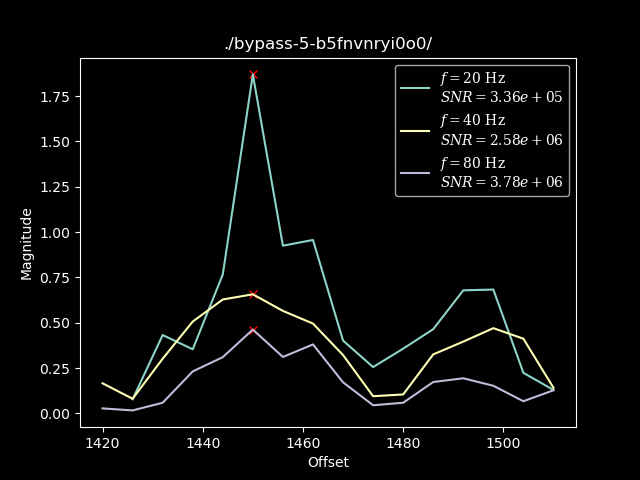

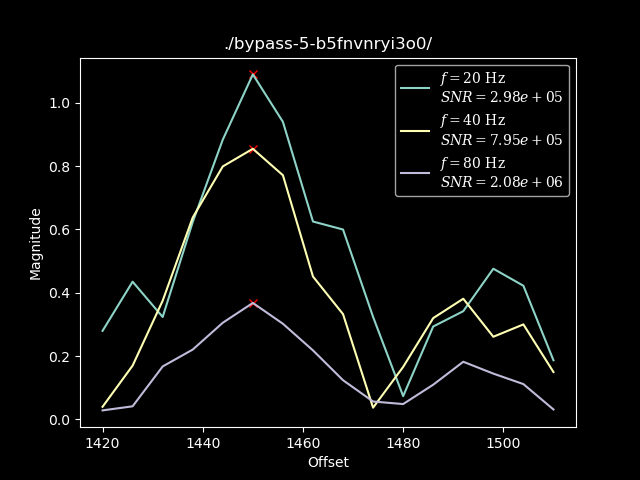

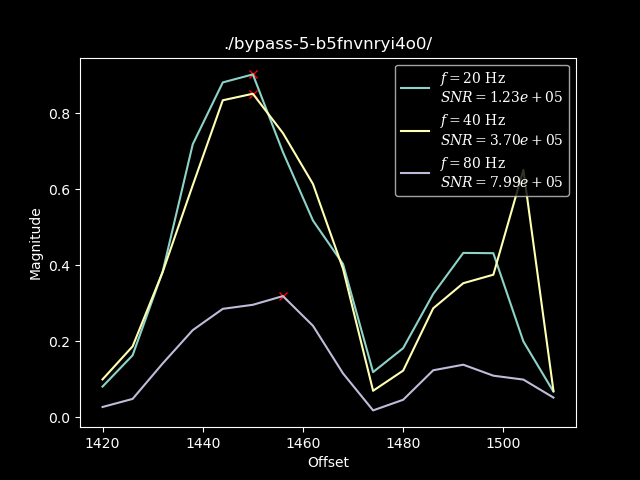

In [15]:
%matplotlib widget

matplotlib.rcParams['mathtext.fontset'] = 'dejavuserif'
font = font_manager.FontProperties(family='serif')



ps_dict = {ps[i]: cp.dir_match(ps[i], "gasx") for i in range(len(ps))}
# print(ps_dict)

values = list(ps_dict.values())

plt.close('all')

for p_idx in range(len(ps)):
    plt.figure()
    plt.title(f"{ps[p_idx]}")
    for freq in freq_list_2:
        bench_test = CEPAS_benchmark(ps[p_idx], test_bench_files, pressure_list[0], freq)
        bench_test.add_magnitude()

        df = bench_test.spectra.spectra_list[0]
        y = df['magnitude_pnorm']
        x = df['offset1']

        bg = CEPAS_noise_info(ps[p_idx]+'noise-tests/')
        bg = bg.get_noise_at(freq)
        SNR = x.max() / bg

        plt.plot(
            df[
                df[
                    'magnitude_pnorm'] == df[
                        'magnitude_pnorm'].max()]['offset1'],
            df[
                df[
                    'magnitude_pnorm'] == df[
                        'magnitude_pnorm'].max()]['magnitude_pnorm'],
            "rx")
        plt.plot(x, y, label=f"$f={freq}\\ \\text{{Hz}}$\n$SNR={SNR:.2e}$")

    plt.legend(prop=font)
    plt.xlabel("Offset")
    plt.ylabel("Magnitude")
    plt.show()